In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('default')
my_colors = [u'#1f77b4',
 u'#ff7f0e',
 u'#2ca02c',
 u'#d62728',
 u'#9467bd',
 u'#8c564b',
 u'#e377c2',
 u'#7f7f7f',
 u'#bcbd22',
 u'#17becf',
 u'#f2f2f2',            
 u'#fffa00',

 u'#b6ff9b',
 u'#005400',
 u'#ffc28c',
 u'#d69c68',
 u'#c1c1c1',
 u'#fbccff',
 u'#ff5e5e',
 u'#00edb2',
 u'#ffca1e',
 u'#933f3f']
col = ['H1','L1','L2','H3','L3','H4','L4','H5','L5','Mix 1','Mix 2','Mix 3','Mix 4',"Gv Gi Gigi and Gc mix",
"Gc partial",
"PI 510757 high N Mead H3.",
"BSB mock R1",
"Bar code BSB mock R2",
"PI505735 mock R1",
"PI505735 mock R2",
"PI297155 mock R1",
"PI297155 mock R2",
"PI510757 mock R1",
"PI510757 mock R2",
" GRASSL mock R1",
"taxon","taxon_rm_UG"]

float("inf")

inf

# #Shell command write sript to get read information for OTU clustering

In [32]:
input_pwd = !ls 9*/all_cluster_*
input_pwd = input_pwd[1:]
script = open("get_header_info.sh","w")
for pwd in input_pwd:
    script.write("perl -ne 'y/@/>/;print($_.<>)&&<>&&<>' "+pwd+" | grep -n \">\" | sed 's/>//' | cut -d \":\" -f 2 > " + pwd.replace("all_cluster_","OTU").replace(".fq",".txt") + "\n")
script.close()


# # run the script

In [33]:
!chmod +x ./get_header_info.sh
!./get_header_info.sh

In [34]:
file_names = !ls 9*/OTU*.txt

TestID= list(set([a.split("/")[0] for a in file_names])) #get unique testID
TestID = sorted(TestID)
#TestID =TestID[:-1]
TestID

['91_maq20',
 '92_maq20',
 '93_maq20',
 '94_maq20',
 '95_maq20',
 '96_maq20',
 '97_maq20',
 '98_maq20']

# #Function: incorporate files into OTU count table

In [25]:
def incorfiles(names):
    a = pd.read_csv(names[0],header=None)
    #a.columns = [names[0].replace(".txt","")]
    a = a.iloc[:,0].str.split("_",expand=True)
    a[3] = a[0] + '_' + a[1]
    a = a.iloc[:,[3,2]]
    a = pd.DataFrame(a.groupby(3).size())
    a.columns = [names[0].replace(".txt","")]
    for each in names[1:]:
        dft = pd.read_csv(each,header=None)
        #a.columns = [names[0].replace(".txt","")]
        dft = dft.iloc[:,0].str.split("_",expand=True)
        dft[3] = dft[0] + '_' + dft[1]
        dft = dft.iloc[:,[3,2]]
        dft = pd.DataFrame(dft.groupby(3).size())
        dft.columns = [each.replace(".txt","")]
        a = pd.merge(a,dft,left_index=True,right_index=True,how="outer")
    return a
#incorfiles([a for a in file_names if TestID[0] in a]).T

# #Function:get % tabble

In [35]:
#incorfiles([a for a in file_names if TestID[0] in a])

def get_per_tb(eachTestID):
    df = incorfiles([a for a in file_names if eachTestID in a]).T
    #df['sort_1'] = [a[0] for a in df.index.str.split("OTU")]
    df['sort_1'] = [a[1] for a in df.index.str.split("/OTU")]
    df = df.astype(float)
    df = df.sort_values(["sort_1"])
    df = df.iloc[:,:-1].T
    df['sort'] = [a[1] for a in df.index.str.split("Test4-AMFmix-2018_")]
    df = df.astype(float)
    df = df.sort_values(["sort"])
    df = df.iloc[:,:-1].T
    df_per = df/df.sum()
    #df_per = df_per.T
    df_per.index = [a.split("/")[1].replace("OTU","OTU_") for a in df_per.index]
    df_per.index.name = "OTU ID"
    return df_per
#get_per_tb(TestID[7])

# #Function:get taxon columns

In [28]:
def tax_genus(pwd):
    tax1 = pd.read_csv(pwd,header=None,sep="\t",index_col=0)
    tax1 = pd.DataFrame(tax1.loc[:,1])
    tax1 = tax1[1].str.split(",",expand=True)
    for i in list(tax1.columns):
        tax1[i] = tax1[i].replace(".+unidentified.+",np.nan,regex=True)
    #tax1[tax1[5] == "None"]
    #tax1[tax1[5].isnull()]
    tax1["taxon"] = ""
    for i in tax1.columns[:-2]:
        add_tax = ~tax1.iloc[:,i].isnull()
        tax1.iloc[:,-1][add_tax] = tax1[add_tax].iloc[:,i]
        tax2 = pd.DataFrame(tax1.iloc[:,-1].str.split("(",expand=True)[0])
        tax2.columns = ["taxon"]
    return tax2


# #Function:get per and taxon table

In [36]:
def get_per_taxon_tb(eachTestID):
    tax = tax_genus(eachTestID + "/best_all_sintax_rm.txt")
    tax.columns = ["taxon_unite"]
    tax_rm_Ug = tax_genus(eachTestID + "/best_all_sintax_rm_unidentifiedG.txt")
    tax_rm_Ug.columns = ["taxon_unite_rmUg"]
    df_per = pd.merge(get_per_tb(eachTestID),tax,left_index=True,right_index=True,how="left")
    df_per = pd.merge(df_per,tax_rm_Ug,left_index=True,right_index=True,how="left")

    df_per["taxon_unite_rmUg"] = df_per["taxon_unite_rmUg"].str.replace("g:Claroideoglomus","Gc").str.replace("g:Rhizophagus","Ri").str.replace("g:Diversispora","Gv").str.replace("g:Gigaspora","Gigi") #simplify the taxon to Gv, Gigi, Ri and Gc
    return df_per
#df_per = get_per_taxon_tb(TestID[7])
#df_per

# #Function: extract_known_samples_taxon table

In [37]:
col_known = ["#1 Mock community (direct amplification)",
    "#2 Mock community diluted (direct amplification)",
    "#4 Mock community (nested amplification)",
    "#5 Mock community diluted (nested amplification)",
    "#6 Field sample Grassl Rep 1 (Direct triplicate)",
    "#7 Field sample Grassl Rep 1 (Nested triplicate)",
    "#8  Field sample Grassl Rep 1 (Nested single)",
    "#9 Field sample 297155 Rep 2 (Direct triplicate)",
    "#10  Field sample 297155 Rep 2 (Nested triplicate)",
    "#11  Field sample 297155 Rep 3 (Direct triplicate)",
    "#12  Field sample 297155 Rep 3 (Nested triplicate)",
    "#13  Field sample 297155 Rep 3 (Nested single)",
    "taxon_unite","taxon_unite_rmUg"]
##ncol legend col
def plot_known_samples(eachTestID,ncol):
    df = get_per_taxon_tb(eachTestID)
    df.columns = col_known
    df = df.sort_values(["taxon_unite_rmUg","taxon_unite"]) ## sort using taxon
    ## remove < 1%
    df.iloc[:,:-2] = df.iloc[:,:-2][df.iloc[:,:-2] > 0.01]
    df = df[~df.iloc[:,:-2].isnull().all(1)]
    
    df["sort_per"] = df.iloc[:,:-2].sum(1)
    dfcount = df.groupby("taxon_unite_rmUg").size()
    dfcount = pd.DataFrame(dfcount)
    dfcount.columns = ["genus_count"]
    df = pd.merge(df,dfcount,left_on="taxon_unite_rmUg",right_index=True,how="left")
    df = df.sort_values(["genus_count","taxon_unite_rmUg","sort_per"],ascending=[False, True,False])
    df =df.iloc[:,:-2]
    ## each genus have a unqiue main color
    len(df["taxon_unite_rmUg"].unique())
    color_list = ["Greens","Blues","Purples","Greys","Wistia","RdPu","Oranges","Reds","pink","winter","cool","bone","spring","magma"] ## main color
    genus = df["taxon_unite_rmUg"].unique()
    
    ## set gradient color for each genus
    df["color"] = "" ## generate one column for color
    for i in np.arange(len(genus)):
        dft = df[df["taxon_unite_rmUg"] == genus[i]]
        mycolor = sns.color_palette(color_list[i], len(dft["taxon_unite_rmUg"])).as_hex()
        df.loc[df["taxon_unite_rmUg"] == genus[i],"color"] = list(reversed(mycolor))    
    
    
    ## change index to fit plt legend
    topind = df.drop_duplicates(subset='taxon_unite_rmUg').index
    topind_num = list(df.reset_index().drop_duplicates(subset='taxon_unite_rmUg').index)
    #df.loc[topind].index = df.loc[topind].index +"\t"+ df.loc[topind,"taxon_unite_rmUg"] 
    dft = df.reset_index()
    dft.loc[topind_num,"OTU ID"] = df.loc[topind].index +"     "+ df.loc[topind,"taxon_unite_rmUg"]
    df = dft.set_index("OTU ID")
    
    
    df.iloc[:,:-3].T.plot(kind='bar', stacked=True,colors=df["color"],figsize=(4,4))
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,prop={'size': 5},ncol=ncol)
    plt.xticks(rotation=90)
    plt.xlabel('sample ID')
    plt.ylabel('Abundance')
    #plt.plot( [4.5,4.5],[0,1.02],linestyle='-',color='k')
    #plt.text(4.8, 1.01, "2nd PacBio run") 
    #plt.text(1, 1.01, "1st PacBio run") 
    for j in np.arange(0,12):
        dft = df.iloc[:,[j,-2]].dropna()
        a = list(dft.iloc[:,0])
        b =[]
        dft1 = dft.copy()
        for i in np.arange(1,len(a)+1):
            b.append(sum(a[:i]))
        dft1.iloc[:,0] = b
        #dft.set_index('taxon_rm_UG')
        ind = list(dft[dft.iloc[:,0] > 0.2].index)
        dft2 = dft1.loc[ind,:]
        for y, label in zip(list(dft2.iloc[:,0]),list(dft2.iloc[:,1])):
            plt.text(j-0.5, y-0.02, label,fontsize=8,rotation='vertical')
    plt.title("OTUs clustering > 5 passes " + eachTestID.replace(".uc","%_identity").replace("all_re_filtered_lensort_OTU_",""))
    #transforms.Affine2D().rotate_deg(90)
    plt.savefig(eachTestID + "_plot.png", bbox_inches='tight')
    return plt.show()
#plot_known_samples(names[7],2)
#plot_known_samples(TestID[7],1)


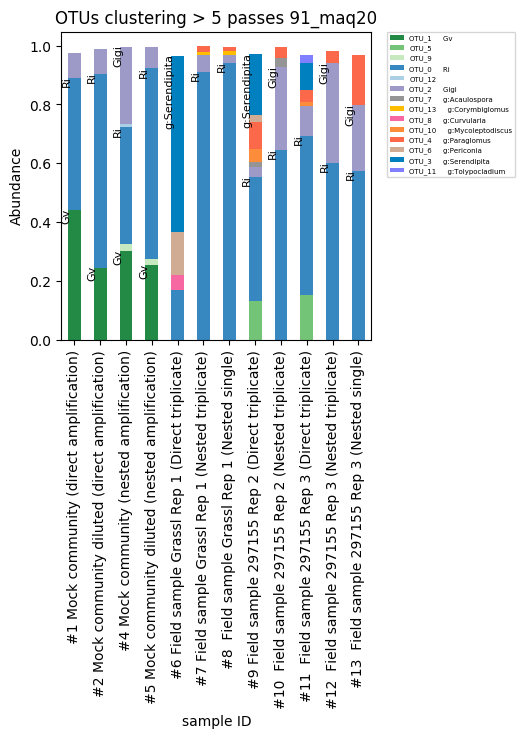

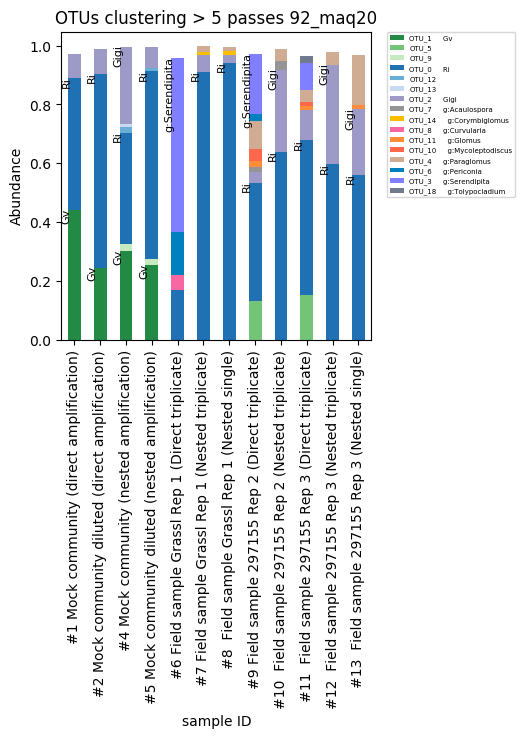

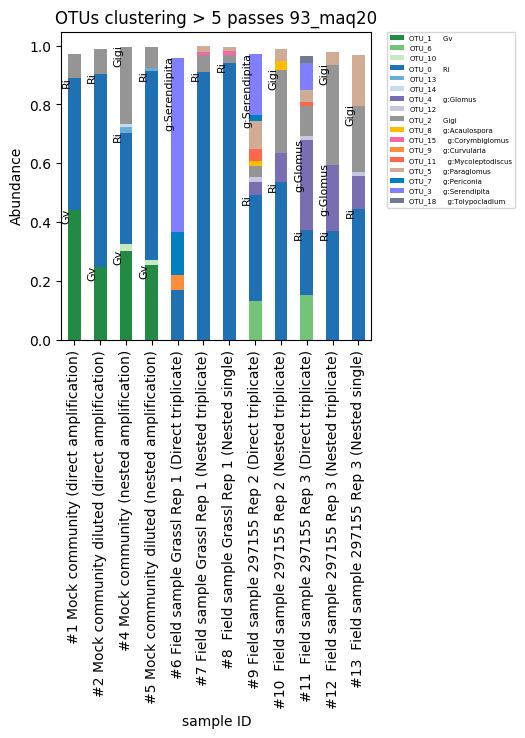

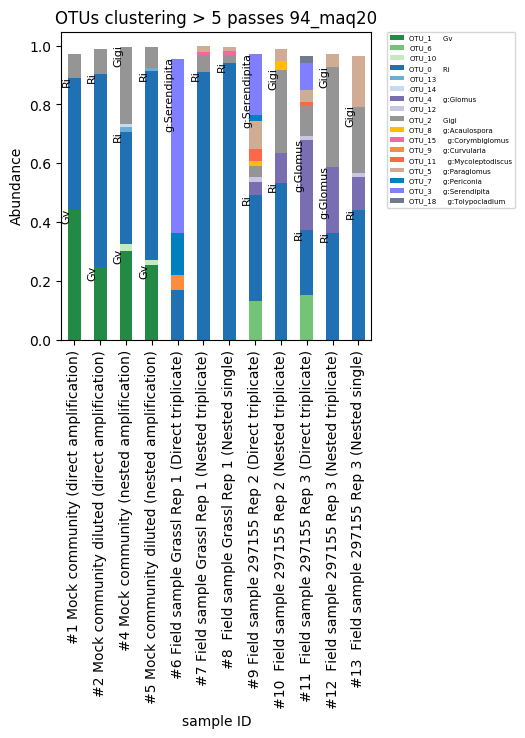

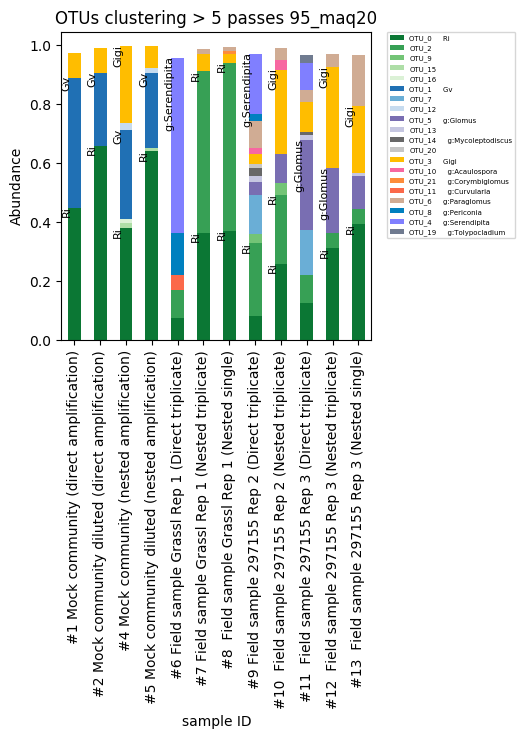

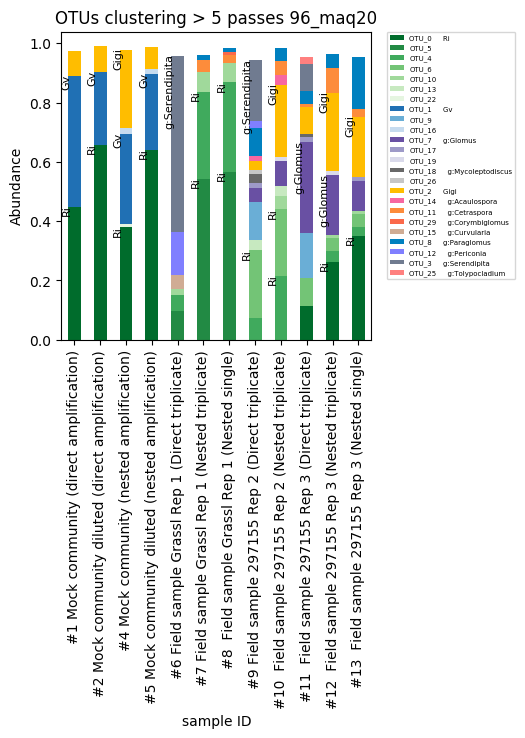

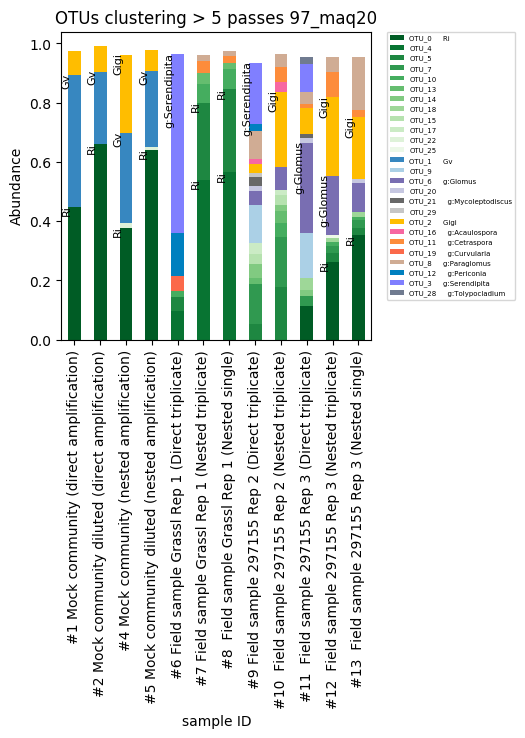

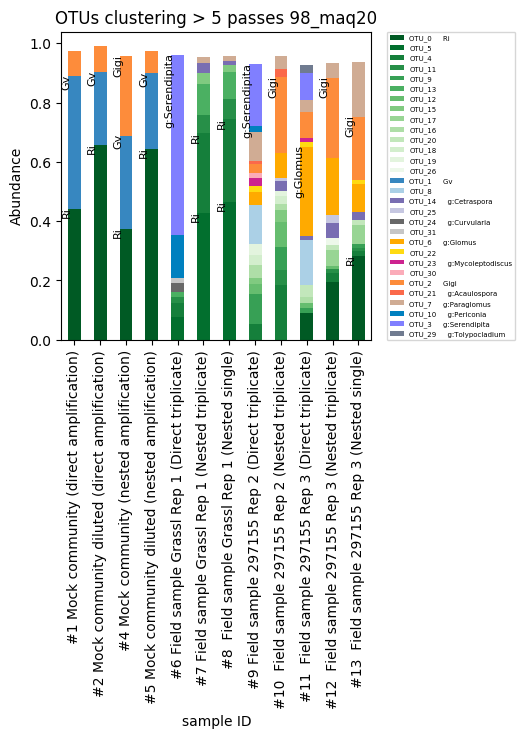

In [31]:
plot_known_samples(TestID[0],1)
plot_known_samples(TestID[1],1)
plot_known_samples(TestID[2],1)
plot_known_samples(TestID[3],1)
plot_known_samples(TestID[4],1)
plot_known_samples(TestID[5],1)
plot_known_samples(TestID[6],1)
plot_known_samples(TestID[7],1)

